In [1]:
from scripts.readers import read_images, read_image, save_TIFF

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import porespy as ps
import importlib as il
import os

from scipy.stats import wilcoxon, ks_2samp, f_oneway
from scipy.ndimage import distance_transform_edt
from scipy.spatial.distance import directed_hausdorff
from skimage.io import imread # read in images
from skimage.measure import regionprops, regionprops_table, shannon_entropy
from skimage.metrics import hausdorff_distance
from sklearn.metrics import roc_curve, auc, jaccard_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from collections import OrderedDict
from importlib.metadata import version

[01:49:08] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=434333;file:///cluster/home/spruthi/miniconda3/envs/qbi2024/lib/python3.9/site-packages/openpnm/utils/_workspace.py\_workspace.py]8;;\:]8;id=584205;file:///cluster/home/spruthi/miniconda3/envs/qbi2024/lib/python3.9/site-packages/openpnm/utils/_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

In [2]:
segment_kmeans_clust = il.import_module("segment.kmeans_clust")
segment_extract_pores = il.import_module("segment.extract_pores")
segment_process_segments = il.import_module("segment.process_segments")
segment_distance_thickness = il.import_module("segment.distance_thickness")

pores_pore_network = il.import_module("pores.pore_network")
pores_pore_regionprops = il.import_module("pores.pore_regionprops")
pores_pore_metric_test = il.import_module("pores.pore_metric_test")

plots_plots_3d = il.import_module("plots.plots_3d")
plots_colormaps_lec = il.import_module("plots.colormaps_lec")

In [3]:
segment_kmeans_clust = il.reload(segment_kmeans_clust)
segment_extract_pores = il.reload(segment_extract_pores)
segment_process_segments = il.reload(segment_process_segments)
segment_distance_thickness = il.reload(segment_distance_thickness)

pores_pore_network = il.reload(pores_pore_network)
pores_pore_regionprops = il.reload(pores_pore_regionprops)
pores_pore_metric_test = il.reload(pores_pore_metric_test)

plots_plots_3d = il.reload(plots_plots_3d)
plots_colormaps_lec = il.reload(plots_colormaps_lec)

In [4]:
# NOTE: Need to implement False
load_single = True # If False, will load all specified bread samples as a list
load_original = True # If False, the original sample image will not be loaded

In [5]:
vx_size = 60.9e-6 # Voxel size in metres

if load_single:
    # start_indices = [150, 299, 180, 300]; start_indices2 = [1420, 1440, 1420, 1440]
    # end_indices = [799, 853, 829, 899]; end_indices2 = [2069, 1994, 2069, 2039]
    # bread_types = ["Ro1a", "Ru1a", "V1a", "W1a"]
    
    start_idx = 1440
    end_idx = 1994
    bread_type = 'Ru1a'
    #save_slice_num = str(int(end_idx-start_idx+1))
    # FIX: automatic slicenum detection
    if bread_type == 'Ro1a':
        save_slice_num = "650"
    elif bread_type == 'Ru1a':
        save_slice_num = "555"
    elif bread_type == 'V1a':
        save_slice_num = "650"
    elif bread_type == 'W1a':
        save_slice_num = "600"
    else:
        print('Check Bread Type')
    output_path = '/cluster/scratch/spruthi/qbi2024_project/'+bread_type+'_save_'+save_slice_num
    if os.path.exists(output_path):
        print('Starting')
    else:
        print('Target path created, check '+output_path)
        os.makedirs(output_path, exist_ok=True)
        # FIX: Need to fix the path
        print('You may want to manually specify save_slice_num')

Starting


In [6]:
if load_single:
    # Load stored images

    # Bread structure (pores = 0)
    connthresh_medfilter3_ds_img_1 = read_images(os.path.join(output_path, (bread_type+'_connthresh_medfilter3_ds_img_1_{0:04}.tif')), start_idx, end_idx)
    print(connthresh_medfilter3_ds_img_1.shape)

    # Filled bread (solid structure)
    filled_pores_1 = read_images(os.path.join(output_path, (bread_type+'_filled_pores_1_{0:04}.tif')), start_idx, end_idx)

    # Pores segmented based on connected components labelling
    merged_labelled_image_lbl = read_images(os.path.join(output_path, (bread_type+'_merged_labelled_image_lbl_{0:04}.tif')), start_idx, end_idx)

    # Pores segmented based on watershed analysis
    merged_labelled_image_ws = read_images(os.path.join(output_path, (bread_type+'_merged_labelled_image_ws_{0:04}.tif')), start_idx, end_idx)

    # Local thicnkess map of pores generated using porespy
    lt_ws = read_images(os.path.join(output_path, (bread_type+'_lt_ws_{0:04}.tif')), start_idx, end_idx)
    
    # Inverted image - extracted pores (if exists)
    if os.path.isfile(os.path.join(output_path, (bread_type+'_inverted_image_1_'+str(start_idx)+'.tif'))):
        inverted_image_1 = read_images(os.path.join(output_path, (bread_type+'_inverted_image_1_{0:04}.tif')), start_idx, end_idx)
        print('Inverted image loaded')
        
    # Original Image
    if load_original:
        img = img = read_images('/cluster/scratch/spruthi/qbi2024_project/'+bread_type+'/'+bread_type+'_0{0:04}.tif', start_idx, end_idx)
        img = img[:,150:1350,150:1350]
        
    # Loading metrics (if needed)
    #df_pair_pore = pd.read_pickle(os.path.join(output_path, (bread_type+'_df_pair_pore.pkl')))
    #df_pair_pore2 = pd.read_pickle(os.path.join(output_path, (bread_type+'_df_pair_pore2.pkl')))

  0%|          | 0/555 [00:00<?, ?it/s]

(555, 1200, 1200)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

Inverted image loaded


  0%|          | 0/555 [00:00<?, ?it/s]

In [ ]:
# Compare segmentations - Jaccard index, Dice, Hausdorff distance
# Radial density distribution (and pore size distribution)
# Pipeline at a glance
# Montage pad - show
# 3d plot of image volume
# Network - porespy and custom

In [ ]:
# img
# connthresh_medfilter3_ds_img_1
# filled_pores_1
# inverted_image_1
# merged_labelled_image_lbl
# merged_labelled_image_ws
# lt_ws

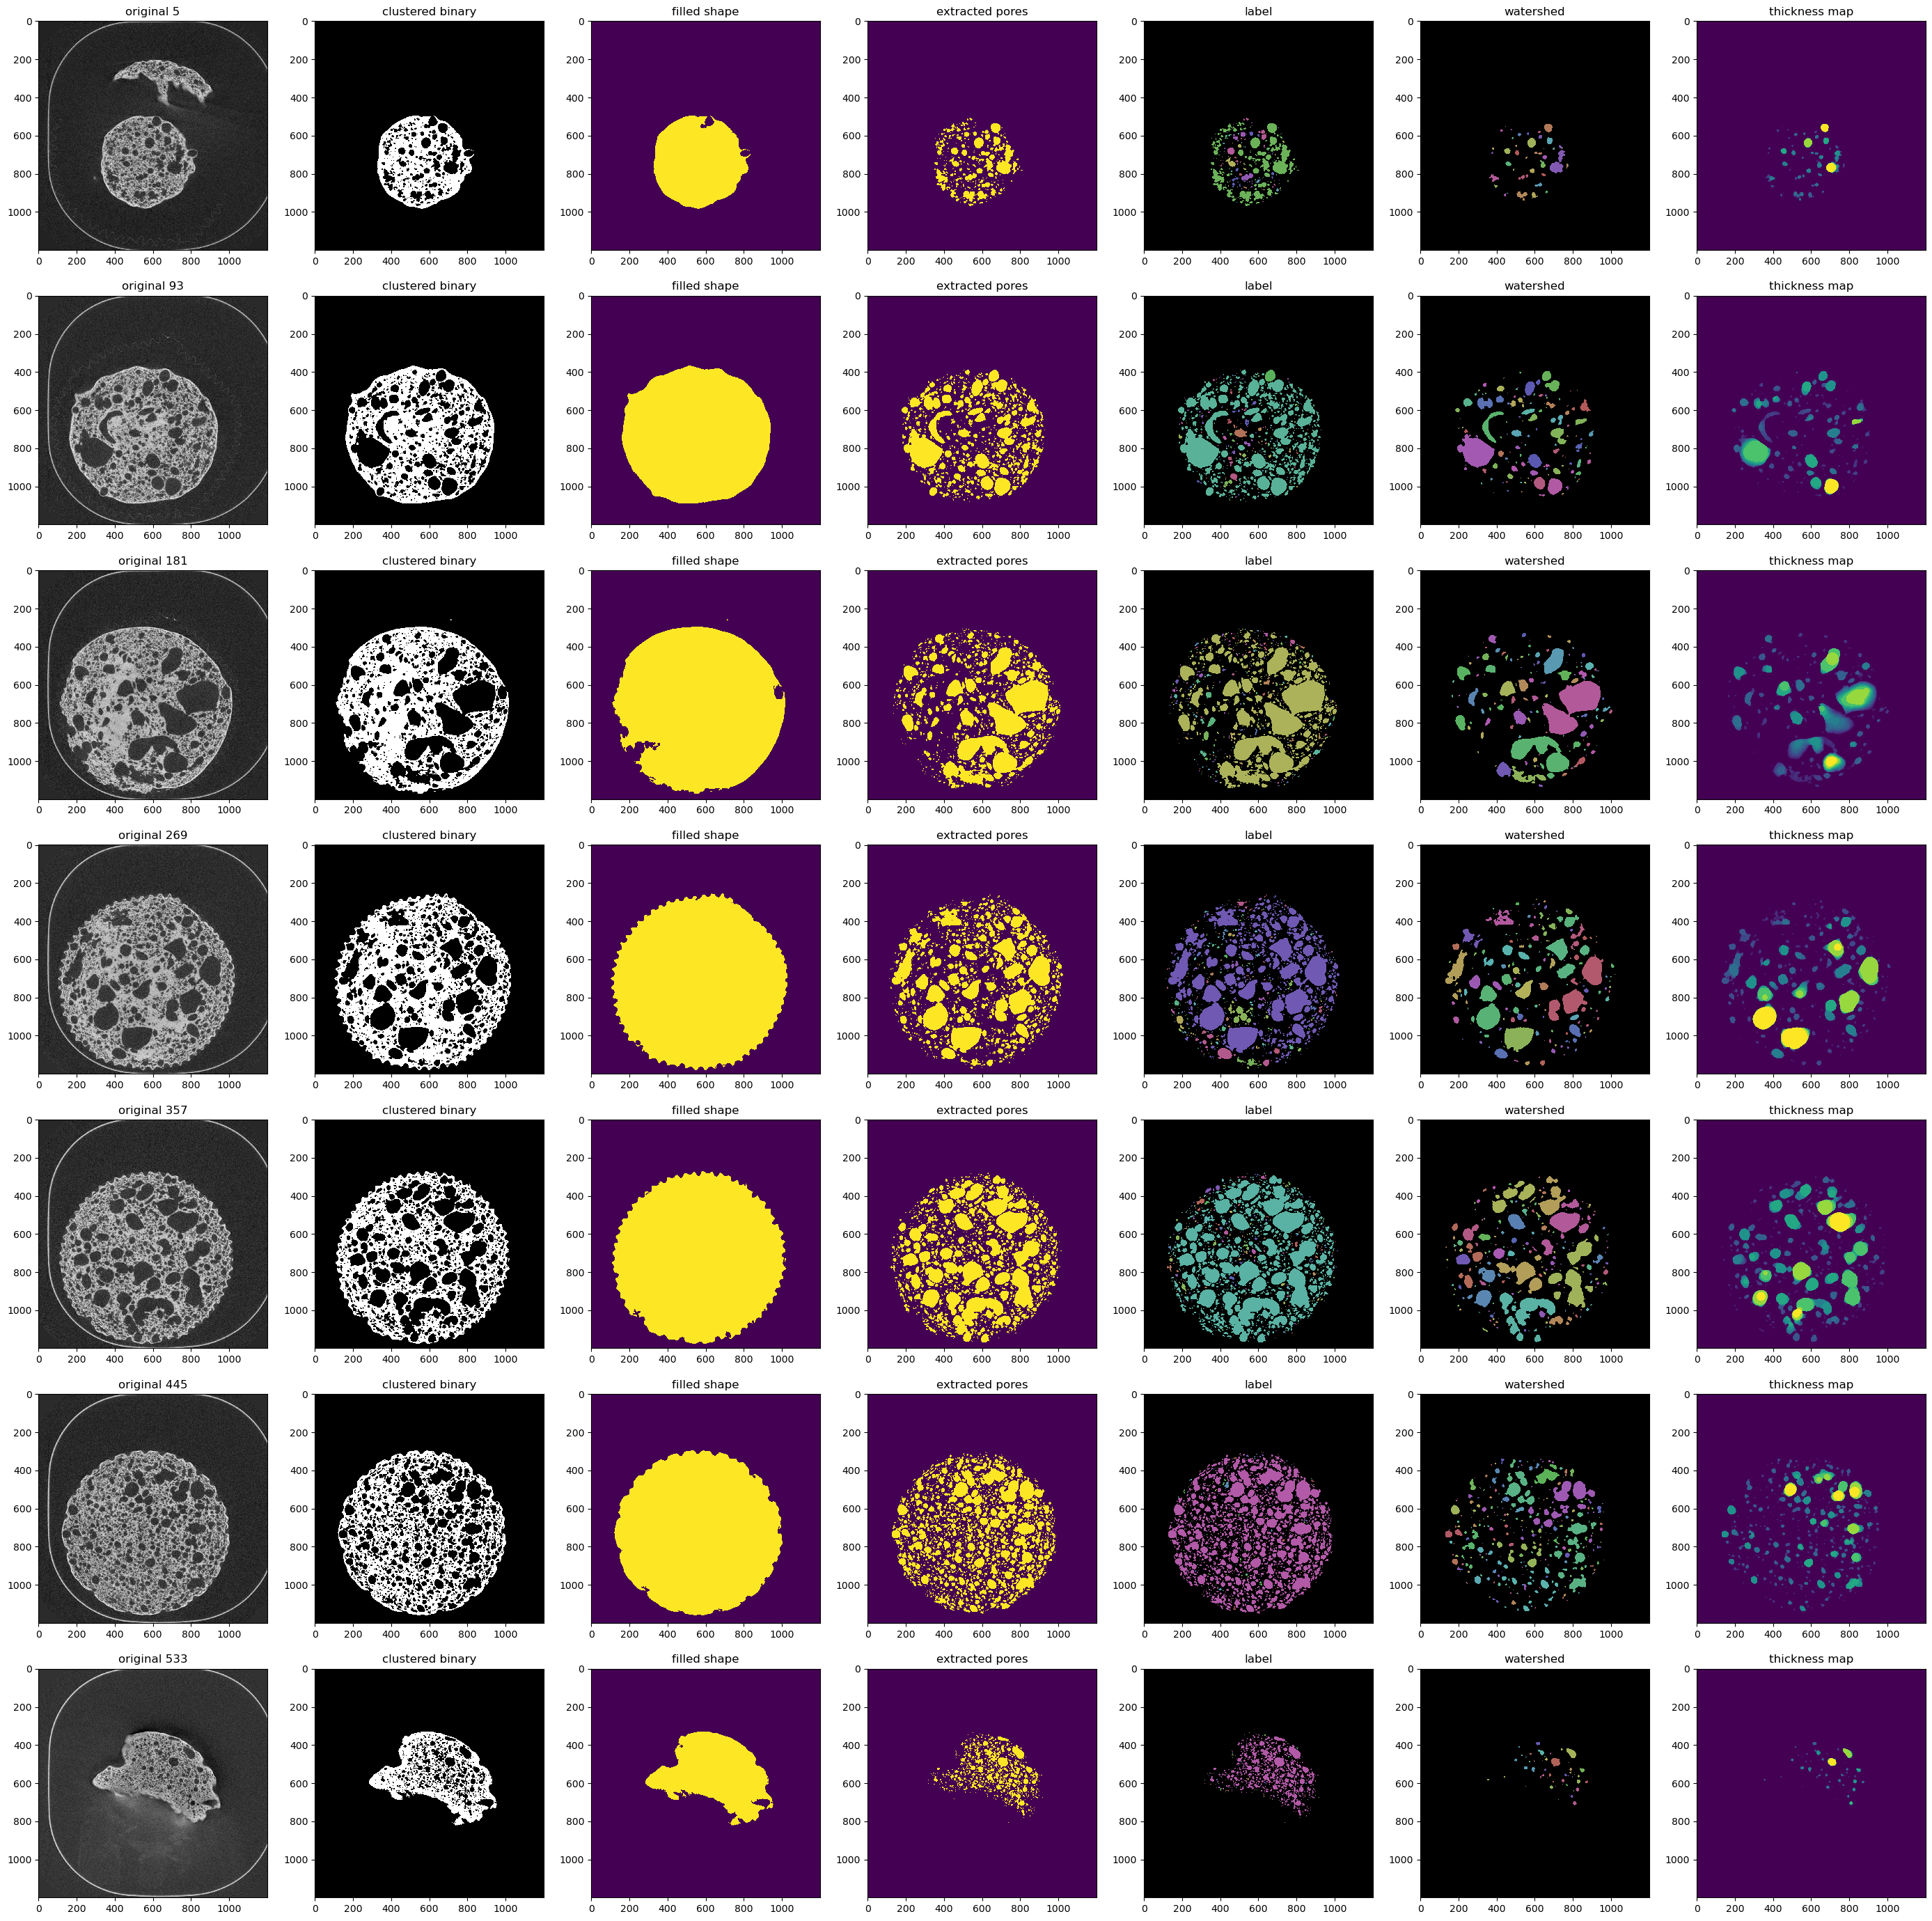

In [24]:
# Pipeline at a glance
goldenCM = getattr(plots_colormaps_lec,"goldenCM")
img_sample = 5
fig, ax = plt.subplots(7,7,figsize=(35,35))

for i in range(7):
    cur_img_sample = img_sample + i*88
    ax[i,0].imshow(img[cur_img_sample], interpolation='none', cmap='gray'); ax[i,0].set_title(f'original {cur_img_sample}')
    ax[i,1].imshow(connthresh_medfilter3_ds_img_1[cur_img_sample], interpolation='none', cmap='gray'); ax[i,1].set_title('clustered binary')
    ax[i,2].imshow(filled_pores_1[cur_img_sample], interpolation='none', cmap='viridis'); ax[i,2].set_title('filled shape')
    ax[i,3].imshow(inverted_image_1[cur_img_sample], interpolation='none', cmap='viridis'); ax[i,3].set_title('extracted pores')
    ax[i,4].imshow(merged_labelled_image_lbl[cur_img_sample], interpolation='none', cmap=goldenCM(int(merged_labelled_image_lbl.max()))); ax[i,4].set_title('label')
    ax[i,5].imshow(merged_labelled_image_ws[cur_img_sample], interpolation='none', cmap=goldenCM(int(merged_labelled_image_ws.max()))); ax[i,5].set_title('watershed')
    ax[i,6].imshow(lt_ws[cur_img_sample], interpolation='none', cmap='viridis'); ax[i,6].set_title('thickness map')

In [ ]:
# Compare Segmentation

# Jaccard index, Dice coefficient, Hausdorff Distance, Volume
dice_coefficient = getattr(pores_pore_metric_test, "dice_coefficient")
hausdorff_distance = getattr(pores_pore_metric_test, "hausdorff_distance")
volume_comparison = getattr(pores_pore_metric_test, "volume_comparison")
jaccard_index = getattr(pores_pore_metric_test, "jaccard_index")

# Comparing merged_labelled_image_lbl and merged_labelled_image_ws
dice = dice_coefficient(merged_labelled_image_ws, merged_labelled_image_lbl)
print(f"Dice Coefficient: {dice}")

jaccard = jaccard_score(merged_labelled_image_ws.ravel(), merged_labelled_image_lbl.ravel(), average='micro')
print(f"Jaccard Score: {jaccard}")

jaccard_idx = jaccard_index(merged_labelled_image_ws, merged_labelled_image_lbl)
print(f"Jaccard Index: {jaccard_idx}")

hausdorff = hausdorff_distance(merged_labelled_image_ws, merged_labelled_image_lbl)
print(f"Hausdorff Distance: {hausdorff}")

vol_ws,vol_lbl = volume_comparison(merged_labelled_image_ws, merged_labelled_image_lbl)
print(f"Volume ws: {vol_ws}")
print(f"Volume lbl: {vol_lbl}")

Dice Coefficient: 0.6845016752220558
Jaccard Score: 0.755987214677304
Jaccard Index: 0.5203364096549492


In [7]:
# Porespy - radial density and pore size
merged_labelled_image_ws_dist = distance_transform_edt(merged_labelled_image_ws)

Text(0.5, 0, 'R (cm) - vx (60.9 um)')

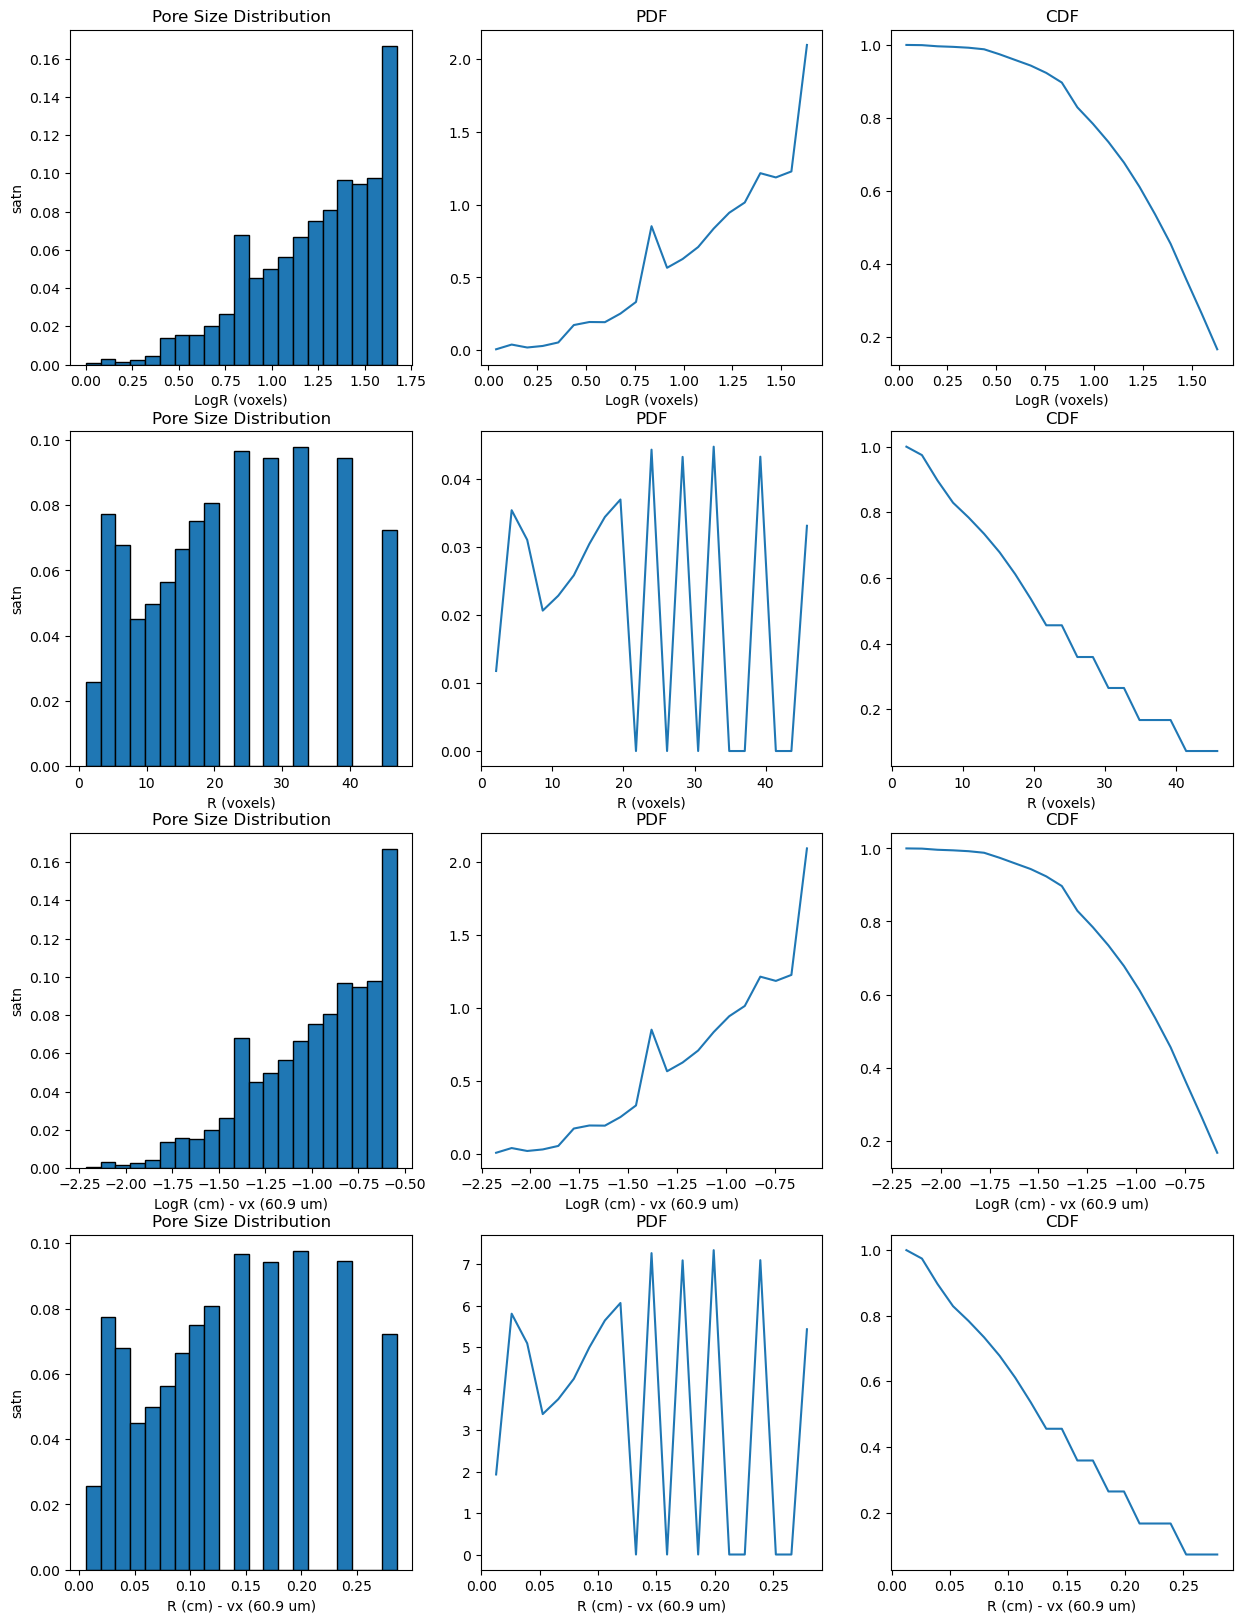

In [18]:
# Pore Size distribution
lt_ws_vx = lt_ws * vx_size * 100 #Voxel size in cm
bins = 21

fig, ax = plt.subplots(4,3,figsize=(15,20))

psd_ws = ps.metrics.pore_size_distribution(lt_ws, bins=bins, log=True)
ax[0,0].bar(psd_ws.LogR, psd_ws.satn, width=psd_ws.bin_widths, edgecolor='k'); ax[0,0].set_ylabel("satn"); ax[0,0].set_xlabel("LogR (voxels)"); ax[0,0].set_title('Pore Size Distribution')
ax[0,1].plot(psd_ws.LogR, psd_ws.pdf); ax[0,1].set_title("PDF"); ax[0,1].set_xlabel("LogR (voxels)")
ax[0,2].plot(psd_ws.LogR, psd_ws.cdf); ax[0,2].set_title("CDF"); ax[0,2].set_xlabel("LogR (voxels)")

psd_ws = ps.metrics.pore_size_distribution(lt_ws, bins=bins, log=False)
ax[1,0].bar(psd_ws.R, psd_ws.satn, width=psd_ws.bin_widths, edgecolor='k'); ax[1,0].set_ylabel("satn"); ax[1,0].set_xlabel("R (voxels)"); ax[1,0].set_title('Pore Size Distribution')
ax[1,1].plot(psd_ws.R, psd_ws.pdf); ax[1,1].set_title("PDF"); ax[1,1].set_xlabel("R (voxels)")
ax[1,2].plot(psd_ws.R, psd_ws.cdf); ax[1,2].set_title("CDF"); ax[1,2].set_xlabel("R (voxels)")

psd_ws_vx = ps.metrics.pore_size_distribution(lt_ws_vx, bins=bins, log=True)
ax[2,0].bar(psd_ws_vx.LogR, psd_ws_vx.satn, width=psd_ws_vx.bin_widths, edgecolor='k'); ax[2,0].set_ylabel("satn"); ax[2,0].set_xlabel("LogR (cm) - vx (60.9 um)"); ax[2,0].set_title('Pore Size Distribution')
ax[2,1].plot(psd_ws_vx.LogR, psd_ws_vx.pdf); ax[2,1].set_title("PDF"); ax[2,1].set_xlabel("LogR (cm) - vx (60.9 um)")
ax[2,2].plot(psd_ws_vx.LogR, psd_ws_vx.cdf); ax[2,2].set_title("CDF"); ax[2,2].set_xlabel("LogR (cm) - vx (60.9 um)")

psd_ws_vx = ps.metrics.pore_size_distribution(lt_ws_vx, bins=bins, log=False)
ax[3,0].bar(psd_ws_vx.R, psd_ws_vx.satn, width=psd_ws_vx.bin_widths, edgecolor='k'); ax[3,0].set_ylabel("satn"); ax[3,0].set_xlabel("R (cm) - vx (60.9 um)"); ax[3,0].set_title('Pore Size Distribution')
ax[3,1].plot(psd_ws_vx.R, psd_ws_vx.pdf); ax[3,1].set_title("PDF"); ax[3,1].set_xlabel("R (cm) - vx (60.9 um)")
ax[3,2].plot(psd_ws_vx.R, psd_ws_vx.cdf); ax[3,2].set_title("CDF"); ax[3,2].set_xlabel("R (cm) - vx (60.9 um)")

Text(0.5, 0, 'R (cm) - vx (60.9 um)')

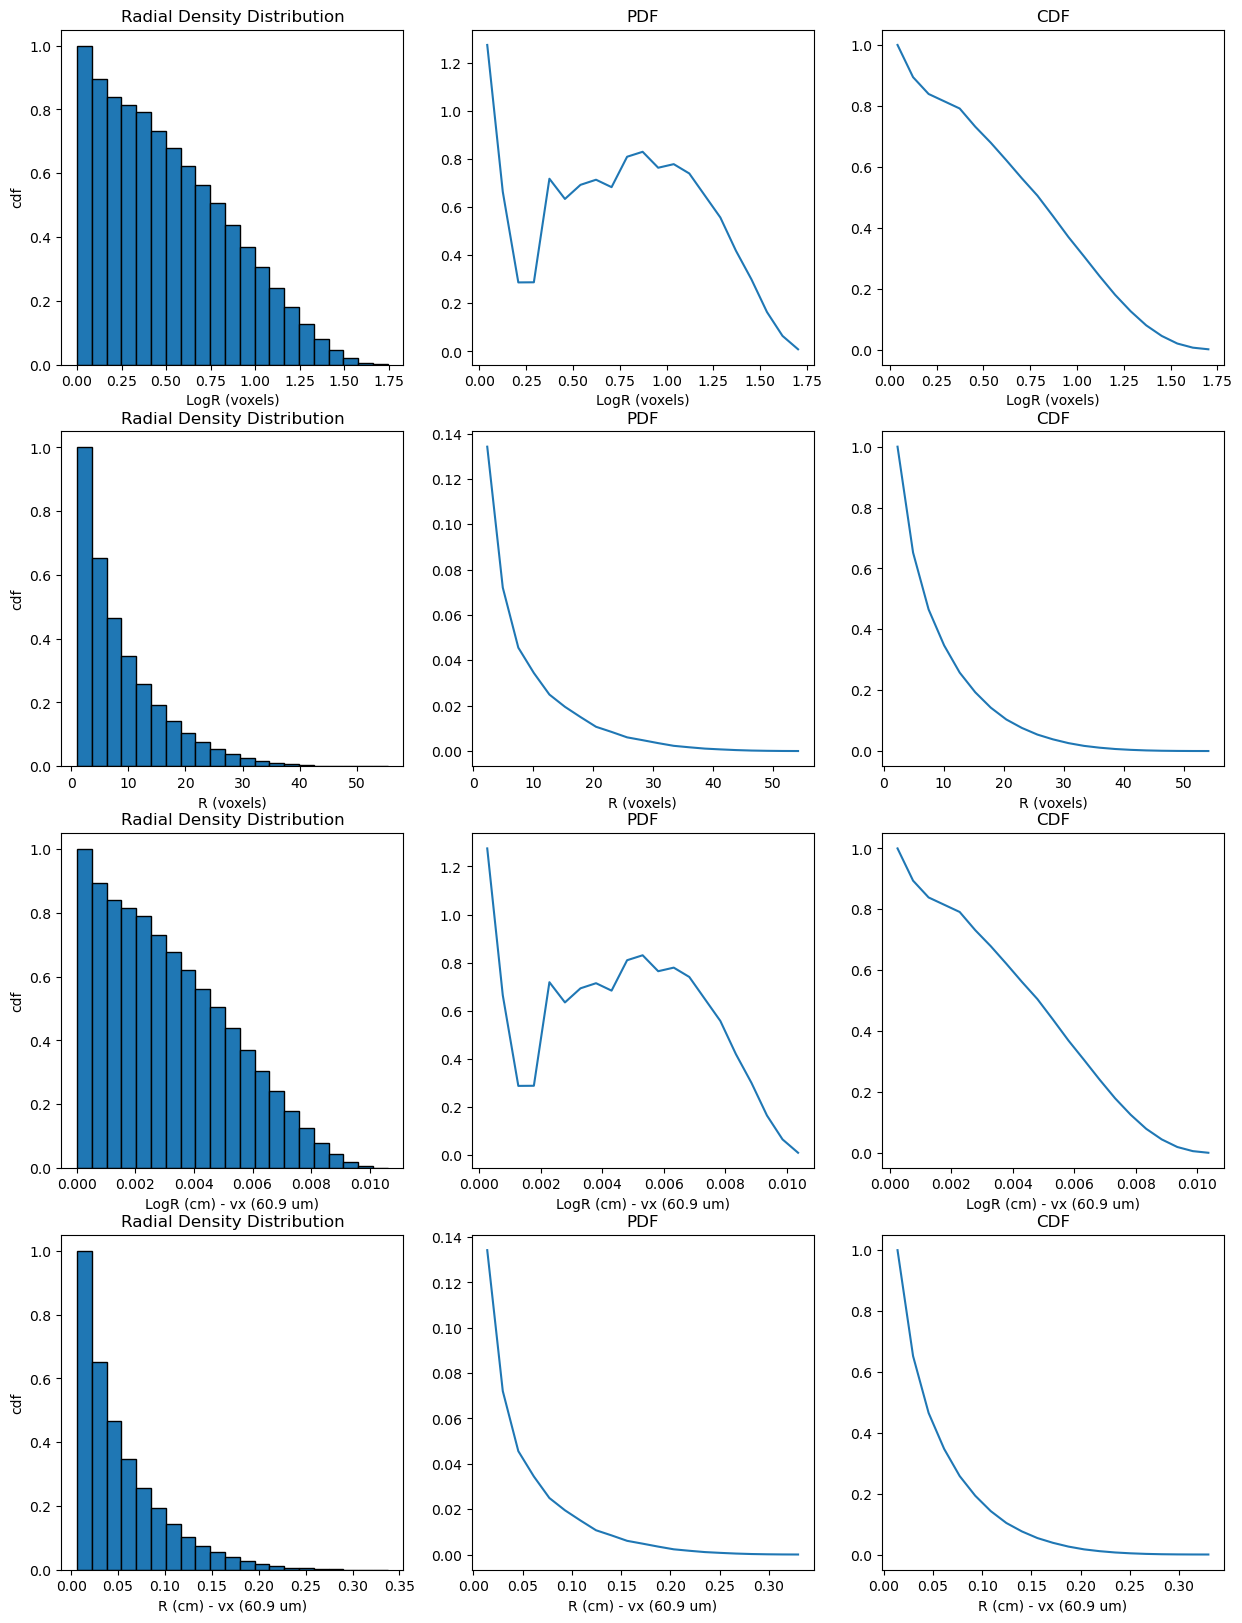

In [19]:
# Radial Density Distribution
fig, ax = plt.subplots(4,3,figsize=(15,20))

rdd_ws = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist, bins=bins, log=True)
ax[0,0].bar(rdd_ws.LogR, rdd_ws.cdf, width=rdd_ws.bin_widths, edgecolor='k'); ax[0,0].set_ylabel("cdf"); ax[0,0].set_xlabel("LogR (voxels)"); ax[0,0].set_title('Radial Density Distribution')
ax[0,1].plot(rdd_ws.LogR, rdd_ws.pdf); ax[0,1].set_title("PDF"); ax[0,1].set_xlabel("LogR (voxels)")
ax[0,2].plot(rdd_ws.LogR, rdd_ws.cdf); ax[0,2].set_title("CDF"); ax[0,2].set_xlabel("LogR (voxels)")

rdd_ws = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist, bins=bins, log=False)
ax[1,0].bar(rdd_ws.R, rdd_ws.cdf, width=rdd_ws.bin_widths, edgecolor='k'); ax[1,0].set_ylabel("cdf"); ax[1,0].set_xlabel("R (voxels)"); ax[1,0].set_title('Radial Density Distribution')
ax[1,1].plot(rdd_ws.R, rdd_ws.pdf); ax[1,1].set_title("PDF"); ax[1,1].set_xlabel("R (voxels)")
ax[1,2].plot(rdd_ws.R, rdd_ws.cdf); ax[1,2].set_title("CDF"); ax[1,2].set_xlabel("R (voxels)")

rdd_ws_vx = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist, bins=bins, log=True, voxel_size=vx_size*100)
ax[2,0].bar(rdd_ws_vx.LogR, rdd_ws_vx.cdf, width=rdd_ws_vx.bin_widths, edgecolor='k'); ax[2,0].set_ylabel("cdf"); ax[2,0].set_xlabel("LogR (cm) - vx (60.9 um)"); ax[2,0].set_title('Radial Density Distribution')
ax[2,1].plot(rdd_ws_vx.LogR, rdd_ws_vx.pdf); ax[2,1].set_title("PDF"); ax[2,1].set_xlabel("LogR (cm) - vx (60.9 um)")
ax[2,2].plot(rdd_ws_vx.LogR, rdd_ws_vx.cdf); ax[2,2].set_title("CDF"); ax[2,2].set_xlabel("LogR (cm) - vx (60.9 um)")

rdd_ws_vx = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist, bins=bins, log=False, voxel_size=vx_size*100)
ax[3,0].bar(rdd_ws_vx.R, rdd_ws_vx.cdf, width=rdd_ws_vx.bin_widths, edgecolor='k'); ax[3,0].set_ylabel("cdf"); ax[3,0].set_xlabel("R (cm) - vx (60.9 um)"); ax[3,0].set_title('Radial Density Distribution')
ax[3,1].plot(rdd_ws_vx.R, rdd_ws_vx.pdf); ax[3,1].set_title("PDF"); ax[3,1].set_xlabel("R (cm) - vx (60.9 um)")
ax[3,2].plot(rdd_ws_vx.R, rdd_ws_vx.cdf); ax[3,2].set_title("CDF"); ax[3,2].set_xlabel("R (cm) - vx (60.9 um)")

In [ ]:
# Montage pad - original, segmented pores, distance
montage_pad = getattr(plots_plots_3d,"montage_pad")

In [ ]:
# 3d plot